# YouTube - viz Data Processing

In [1]:
import os

In [2]:
os.environ["ARROW_PRE_0_15_IPC_FORMAT"] = "1"

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

In [4]:
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType

In [5]:
spark = (
    SparkSession.builder.master("local[24]")
    .appName("YouTubeVizLocal")
    .config("spark.driver.memory", "16g")
    .config("spark.executor.memory", "32g")
    .getOrCreate()
)

## Preprocessing
Rescale weights and filter to interesting time range

In [7]:
df = spark.read.parquet('/scratch/tvaucher/data/helper.parquet')

In [8]:
df.printSchema()

root
 |-- categories: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- dislike_count: long (nullable = true)
 |-- display_id: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- like_count: long (nullable = true)
 |-- upload_date: timestamp (nullable = true)
 |-- view_count: long (nullable = true)
 |-- channel: string (nullable = true)
 |-- prob: double (nullable = true)
 |-- categories_raw: string (nullable = true)
 |-- semester: long (nullable = true)
 |-- category_mode: string (nullable = true)
 |-- top1p_cat: boolean (nullable = true)
 |-- top1p_g_cat: boolean (nullable = true)
 |-- top1p: boolean (nullable = true)
 |-- year: long (nullable = true)
 |-- top1p_g: boolean (nullable = true)
 |-- weight: double (nullable = true)
 |-- __index_level_0__: long (nullable = true)



In [9]:
df.select('categories').distinct().collect()

[Row(categories='Gaming'),
 Row(categories='Entertainment'),
 Row(categories='Education, Science & Tech'),
 Row(categories='Howto & Style'),
 Row(categories='News & Politics'),
 Row(categories='Music'),
 Row(categories='Others')]

In [10]:
all_cat = sorted([x['categories'] for x in _])

In [11]:
all_cat

['Education, Science & Tech',
 'Entertainment',
 'Gaming',
 'Howto & Style',
 'Music',
 'News & Politics',
 'Others']

In [12]:
start_date = '2008-01-07'
end_date = '2019-06-30'

In [13]:
min_weight = df.agg(F.min('weight')).collect()[0]['min(weight)']

In [14]:
upper_quantile = df.stat.approxQuantile('weight', [0.75], 0.5)[0]

In [15]:
@F.pandas_udf("integer", F.PandasUDFType.SCALAR)
def scale(x):
    return (x.clip(0, upper_quantile) / min_weight).round().astype(int)

In [16]:
scaled = df.repartitionByRange(48, 'categories', 'upload_date').\
           .select('categories', 'view_count',
                   scale('weight').alias('weight'),
                   'upload_date')\
           .filter(F.col('upload_date').between(start_date, end_date))#\
           #.cache()

In [17]:
scaled.withColumn('date', F.date_trunc('week', 'upload_date'))\
      .withColumn('score', scaled.view_count * scaled.weight)\
      .groupBy('date')\
      .pivot('categories', all_cat)\
      .sum('score')\
      .orderBy('date')

DataFrame[date: timestamp, Education, Science & Tech: bigint, Entertainment: bigint, Gaming: bigint, Howto & Style: bigint, Music: bigint, News & Politics: bigint, Others: bigint]

In [18]:
week_score = _ #.cache()

In [19]:
week_score_df = week_score.toPandas()

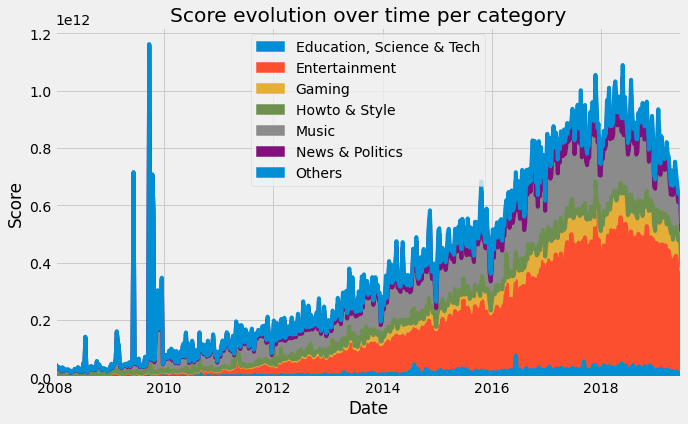

In [20]:
week_score_df.set_index('date').plot.area()
plt.title('Score evolution over time per category')
plt.xlabel('Date')
plt.ylabel('Score')
plt.savefig('score_over_time.png', dpi=300)

In [22]:
week_score_df.set_index('date').to_csv('../website/data/score/score_week.csv')